In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

import string
import warnings
import missingno
warnings.filterwarnings('ignore')

In [2]:
df_test = pd.read_csv('/Users/miji.lee/Desktop/ML Practice/bike_sharing/test.csv')
df_train = pd.read_csv('/Users/miji.lee/Desktop/ML Practice/bike_sharing/train.csv')
df_all = pd.concat((df_train, df_test)).reset_index(drop= True)
df_all.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3.0,13.0,16.0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8.0,32.0,40.0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5.0,27.0,32.0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3.0,10.0,13.0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0.0,1.0,1.0


In [4]:
df_train.shape

(10886, 12)

In [ ]:
df_test.shape

# 만약 합쳐진 상태에서 test, train으로 나누려면
# df_train = df_all[:10885]
# df_test = df_all[10886:]
# 혹은
def split_df(df):
    return df[:10885], df[10886:]

(6493, 9)

In [54]:
# datatime 컬럼 일자로 바꿔주기
df_train['datetime'] = pd.to_datetime(df_train['datetime'], format = '%Y-%m-%d %H:%M:%S', errors = 'raise') # format: 현재 타입은 무엇임을 인지시키기. errors: 에러나면 멈추기
df_train.groupby(pd.Grouper(key = 'datetime', freq= 'D')).mean().head() # 날짜별로 평균 내기 

# grouper: 단순 groupby('컬럼')보다 더 복잡한 기준을 적용할 수 있음
# 멀티인덱스, 시간인덱스, 시간 데이터를 월별, 분기별, 연별 등으로 쉽게 묶을 수 있음
# freq = 'D' : day 날짜별로그루핑

TypeError: agg function failed [how->mean,dtype->object]

In [55]:
df_train['datetime_timestamp'] = pd.to_datetime(df_train['datetime'], format = '%Y-%m-%d %H:%M:%S')
df_train['datetime_timestamp'].dt.strftime('%Y-%m-%d').unique()
# .dt: datetime관련 메서드/속성을 매 줄마다 적용 (.str같이)
# .strftime(format): 날짜/시간을 원하는 형식의 '문자열'로 반환

array(['2011-01-01', '2011-01-02', '2011-01-03', '2011-01-04',
       '2011-01-05', '2011-01-06', '2011-01-07', '2011-01-08',
       '2011-01-09', '2011-01-10', '2011-01-11', '2011-01-12',
       '2011-01-13', '2011-01-14', '2011-01-15', '2011-01-16',
       '2011-01-17', '2011-01-18', '2011-01-19', '2011-02-01',
       '2011-02-02', '2011-02-03', '2011-02-04', '2011-02-05',
       '2011-02-06', '2011-02-07', '2011-02-08', '2011-02-09',
       '2011-02-10', '2011-02-11', '2011-02-12', '2011-02-13',
       '2011-02-14', '2011-02-15', '2011-02-16', '2011-02-17',
       '2011-02-18', '2011-02-19', '2011-03-01', '2011-03-02',
       '2011-03-03', '2011-03-04', '2011-03-05', '2011-03-06',
       '2011-03-07', '2011-03-08', '2011-03-09', '2011-03-10',
       '2011-03-11', '2011-03-12', '2011-03-13', '2011-03-14',
       '2011-03-15', '2011-03-16', '2011-03-17', '2011-03-18',
       '2011-03-19', '2011-04-01', '2011-04-02', '2011-04-03',
       '2011-04-04', '2011-04-05', '2011-04-06', '2011-

In [44]:
df_test['datetime_timestamp'] = pd.to_datetime(df_test['datetime'], format = '%Y-%m-%d %H:%M:%S')
df_test['datetime_timestamp'].dt.strftime('%Y-%m-%d').unique()

array(['2011-01-20', '2011-01-21', '2011-01-22', '2011-01-23',
       '2011-01-24', '2011-01-25', '2011-01-26', '2011-01-27',
       '2011-01-28', '2011-01-29', '2011-01-30', '2011-01-31',
       '2011-02-20', '2011-02-21', '2011-02-22', '2011-02-23',
       '2011-02-24', '2011-02-25', '2011-02-26', '2011-02-27',
       '2011-02-28', '2011-03-20', '2011-03-21', '2011-03-22',
       '2011-03-23', '2011-03-24', '2011-03-25', '2011-03-26',
       '2011-03-27', '2011-03-28', '2011-03-29', '2011-03-30',
       '2011-03-31', '2011-04-20', '2011-04-21', '2011-04-22',
       '2011-04-23', '2011-04-24', '2011-04-25', '2011-04-26',
       '2011-04-27', '2011-04-28', '2011-04-29', '2011-04-30',
       '2011-05-20', '2011-05-21', '2011-05-22', '2011-05-23',
       '2011-05-24', '2011-05-25', '2011-05-26', '2011-05-27',
       '2011-05-28', '2011-05-29', '2011-05-30', '2011-05-31',
       '2011-06-20', '2011-06-21', '2011-06-22', '2011-06-23',
       '2011-06-24', '2011-06-25', '2011-06-26', '2011-

<Axes: >

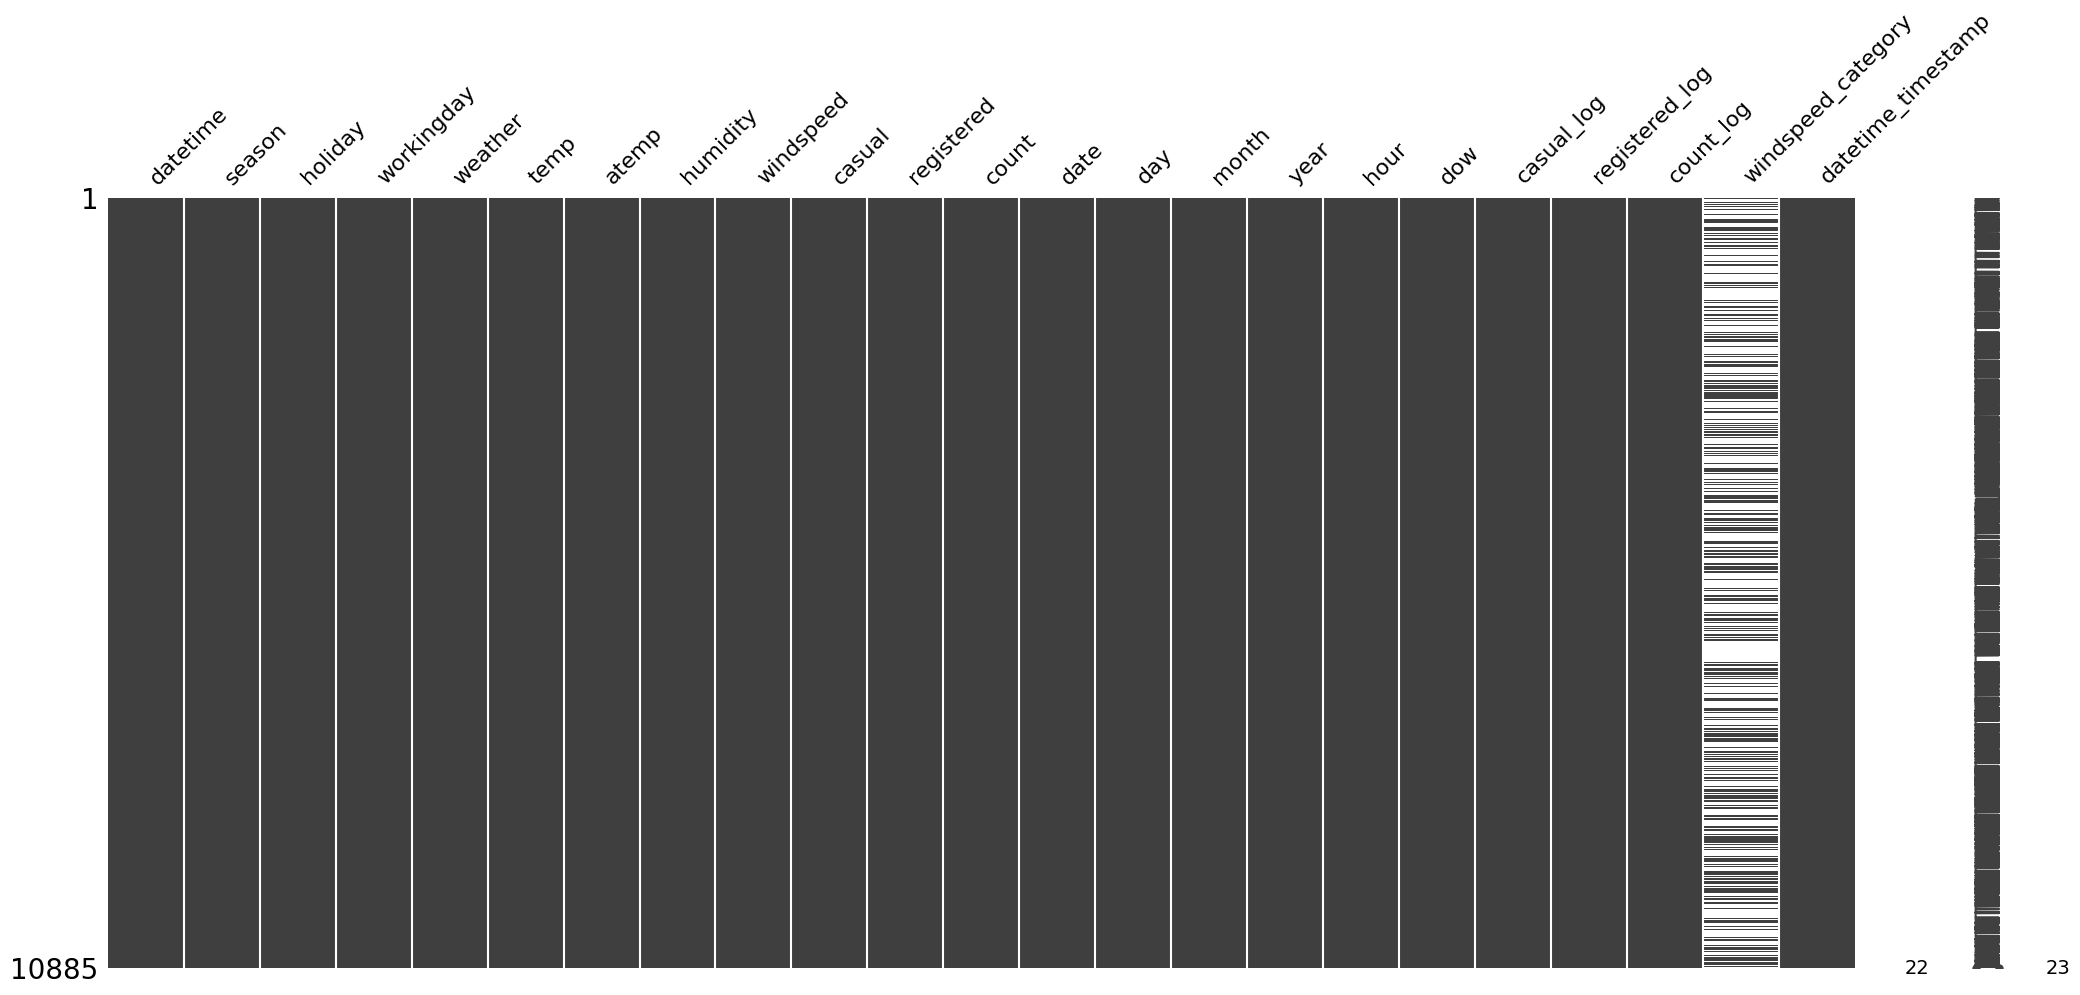

In [56]:
missingno.matrix(df_train) # 결측치 없음

<Axes: >

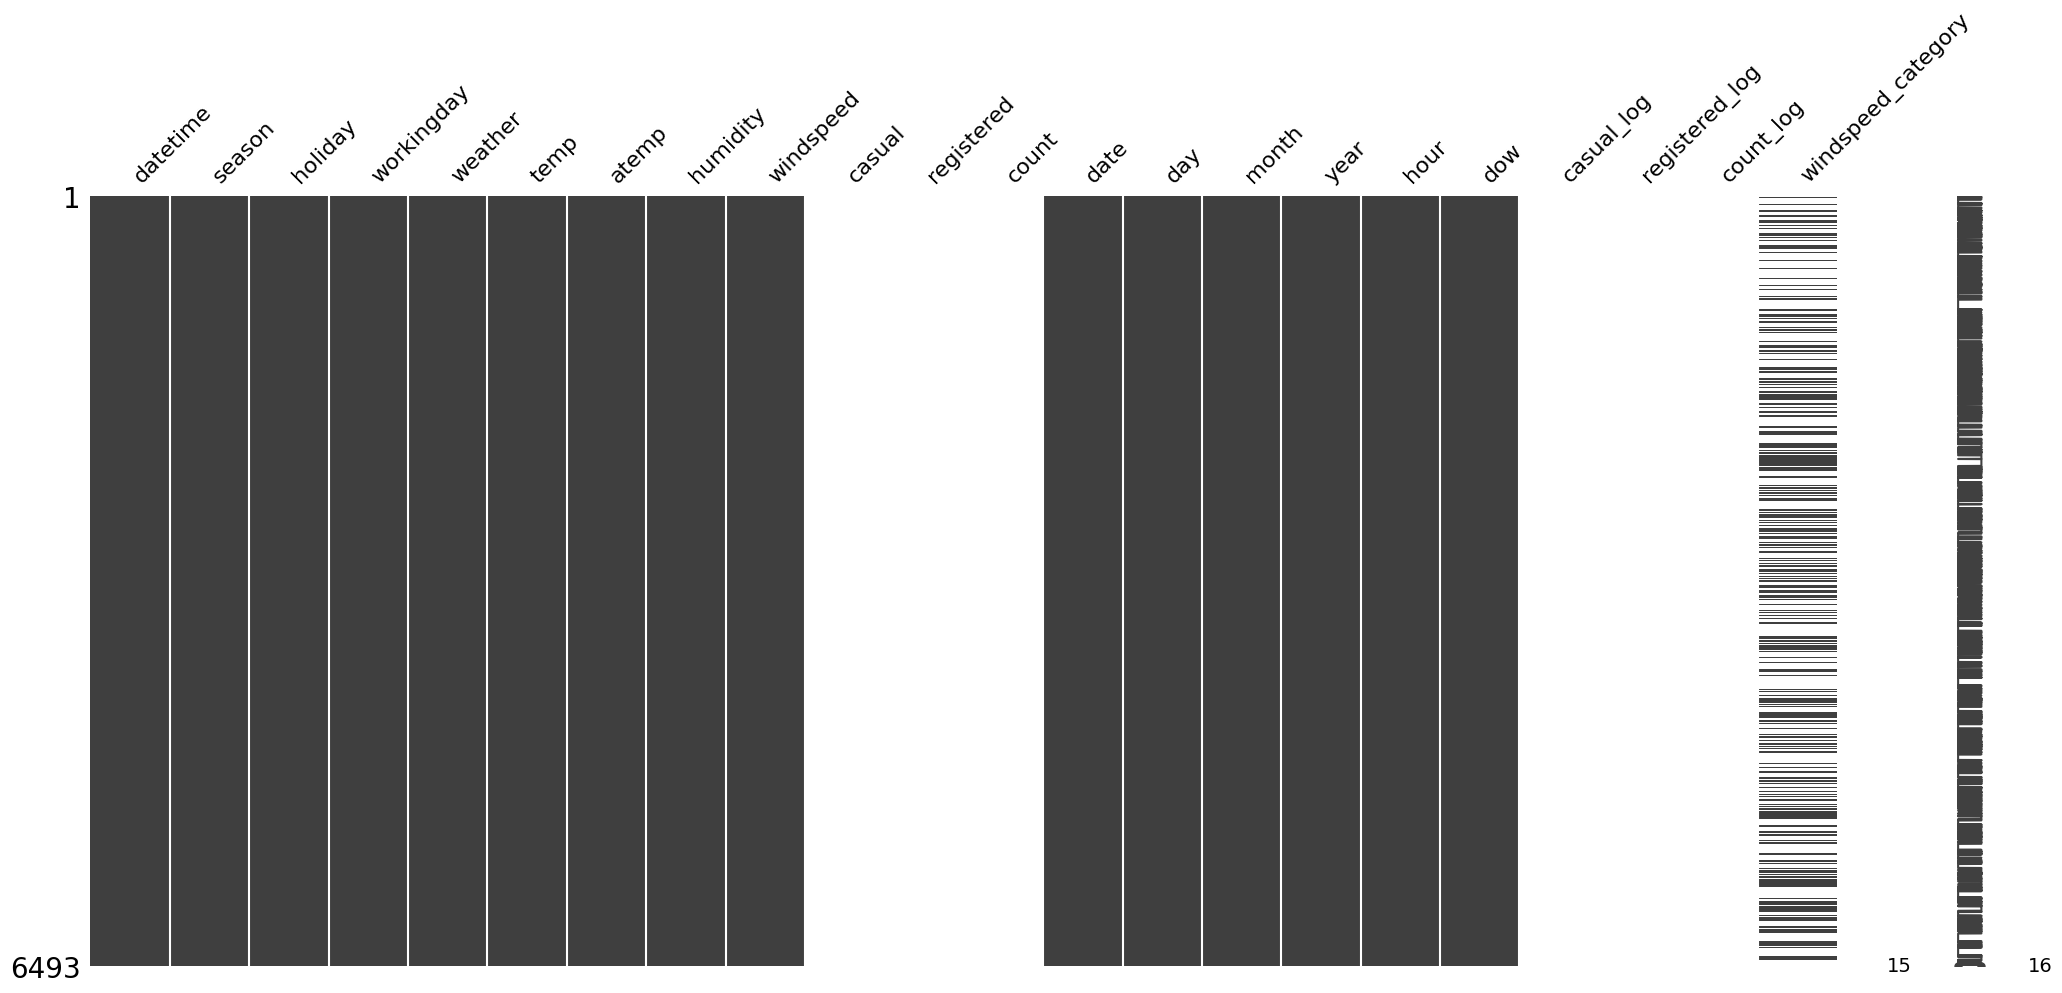

In [57]:
missingno.matrix(df_test)

In [58]:
dt = pd.DatetimeIndex(df_all['datetime'])
dt

DatetimeIndex(['2011-01-01 00:00:00', '2011-01-01 01:00:00',
               '2011-01-01 02:00:00', '2011-01-01 03:00:00',
               '2011-01-01 04:00:00', '2011-01-01 05:00:00',
               '2011-01-01 06:00:00', '2011-01-01 07:00:00',
               '2011-01-01 08:00:00', '2011-01-01 09:00:00',
               ...
               '2012-12-31 14:00:00', '2012-12-31 15:00:00',
               '2012-12-31 16:00:00', '2012-12-31 17:00:00',
               '2012-12-31 18:00:00', '2012-12-31 19:00:00',
               '2012-12-31 20:00:00', '2012-12-31 21:00:00',
               '2012-12-31 22:00:00', '2012-12-31 23:00:00'],
              dtype='datetime64[ns]', name='datetime', length=17379, freq=None)

In [59]:
dt = pd.DatetimeIndex(df_all['datetime']) # 인덱스 전용 객체. 시간 인덱스 정보만 담고 있음.
df_all.set_index(dt, inplace = True) # df_all의 인덱스를 날짜로 바꾼다

df_all['date'] = dt.date # 숫자 인덱스 중 날짜 부분만 취한다 
df_all['day'] = dt.day
df_all['month'] = dt.month
df_all['year'] = dt.year
df_all['hour'] = dt.hour
df_all['dow'] = dt.dayofweek
# df_all['woy'] = dt.weekofyear

In [60]:
df_all['casual_log'] = np.log(df_all['casual']+1) # np.log: 자연로그 만들기
df_all['registered_log'] = np.log(df_all['registered']+1)
df_all['count_log'] = np.log(df_all['count']+1)

In [64]:
# time 기반 ETA

import plotly.graph_objects as go
from plotly.subplots import make_subplots

def visualise(column_name):
    df_train_workingday_time = df_train.groupby(['workingday', column_name]).sum()
    df_train_workingday_time = df_train_workingday_time.reset_index()
    
    times_nonworkday = df_train_workingday_time[df_train_workingday_time['workingday']==0][column_name]
    counts_nonworkday = df_train_workingday_time[df_train_workingday_time['workingday']==0][column_name]
    
    times_workday = df_train_workingday_time[df_train_workingday_time['workingday']==1][column_name]
    counts_workday = df_train_workingday_time[df_train_workingday_time['workingday']==1][column_name]
    
    df_temp_workday = pd.concat([times_workday, counts_workday], axis =1, keys = [column_name, 'count'])
    df_temp_nonworkday = pd.concat([times_nonworkday, counts_nonworkday], axis =1, keys = [column_name, 'count'])
    
    fig = make_subplots(rows = 1, cols = 2, subplot_titles=('workday', 'non-workday'))
    fig.add_trace(
        go.Bar(x=df_temp_workday[column_name], 
               y= df_temp_workday['count'],
               text = df_temp_workday['count'],
               textposition= 'auto',
               texttemplate='%{text:.0f}',
               row = 1,
               col = 1
               )
    )
    fig.add_trace(
        go.Bar(x = df_temp_nonworkday[column_name],
               y = df_temp_nonworkday['count'],
                text = df_temp_nonworkday['count'],
               textposition= 'auto',
                texttemplate='%{text:.0f}',
               row = 1,
               col = 2
        )
        )
    fig.update_layout(showlegend = False)
    fig.show()


In [65]:
visualise('dow')

TypeError: datetime64 type does not support sum operations

In [53]:
visualise('woy')

KeyError: 'woy'

In [30]:
visualise('hour')

TypeError: unsupported operand type(s) for +: 'datetime.date' and 'datetime.date'

In [31]:
df_train, df_test = split_df(df_all)

df_train_workingday_hour = df_train.groupby(['workingday', 'hour']).sum()
df_train_workingday_hour = df_train_workingday_hour.reset_index()

hours_nonworkday = df_train_workingday_hour[df_train_workingday_hour['workingday']==0]['hour']
counts_nonworkday - df_train_workingday_hour[df_train_workingday_hour['workingday']==0]['count']

hours_workday = df_train_workingday_hour[df_train_workingday_hour['workingday']==1]['hour']
counts_workday - df_train_workingday_hour[df_train_workingday_hour['workingday']==1]['count']

df_temp_workday = pd.concat([hours_workday, counts_workday], axis =1, keys = ['hour', 'count'])
df_temp_nonworkday = pd.concat([hours_nonworkday, counts_nonworkday], axis =1, keys = ['hour', 'count'])

TypeError: unsupported operand type(s) for +: 'datetime.date' and 'datetime.date'

In [33]:
fig = go.Figure()
fig.add_trace(
    go.Bar(x = df_temp_workday['hour'],
           y = df_temp_workday['count'],
           text = df_temp_workday['count'],
           textposition='auto',
           )
)
fig.update_layout({
    'title':{'text':"<b>workday<b>"},
    'xaxis':{'showticklabels':True, 'dtick':'1'},
    'template':'ggplot2'
})
fig.show()

fig = go.Figure()
fig.add_trace(
    go.Bar(x = df_temp_nonworkday['hour'],
           y = df_temp_nonworkday['count'],
           text = df_temp_nonworkday['count'],
           textposition='auto',
           )
)
fig.update_layout({
    'title':{'text':"<b>non-workday<b>"},
    'xaxis':{'showticklabels':True, 'dtick':'1'},
    'template':'seaborn'
})
fig.show()

NameError: name 'df_temp_workday' is not defined

In [ ]:
# 위에서 안 내용을 바탕으로 peak 시간 채움

def func(df_data):
    if df_data['workingday']==1:
        if(df_data['hour']==8) or (df_data['hour']>=17 and df_data['hour']<=18):
            return 1
    else:
        if (df_data['hour']>=10 and df_data['hour']<=19):
            return 1
    return 0

df_all['peak'] = df_all.apply(func, axis =1)

In [ ]:
# 상관관계 분석

df_train.columns

In [ ]:
df_train_corr = df_train[['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered']]

# date, day, month, year, hour,dow, woy같은 날짜 데이터는 상관관계가 안보일 것 같아

In [ ]:
corr_matrix = df_train.corr() #  전부 숫자이므로 옵션 없이 corr
text_values = np.round(corr_matrix.values,2)

fig = go.Figure(data = go.Heatmap(
    z = corr_matrix.values,
    x = corr_matrix.columns,
    y = corr_matrix.index,
    colorscale='Blues',
    zmin = -1,
    zmax = 1,
    text = text_values,
    texttemplate='%{text}'
))

fig.update_layout(
    title = 'Correlation Heatmap'
)

fig.show()

# 온도, 풍속, 습도에 영향 받는 자전거 대여 횟수

In [ ]:
# 연속형 값이므로 범주형으로 바꾸자

df_all.loc[df_all['windspeed']<=5, 'windspeed_category']=0
df_all.loc[(df_all['windspeed']>5) & (df_all['windspeed']<=10), 'windspeed_category']=1
df_all.loc[(df_all['windspeed']>10) & (df_all['windspeed']<=15), 'windspeed_category']=2
df_all.loc[(df_all['windspeed']>15) & (df_all['windspeed']<=20), 'windspeed_category']=3
df_all.loc[(df_all['windspeed']>20) & (df_all['windspeed']<=25), 'windspeed_category']=4
df_all.loc[(df_all['windspeed']>25) & (df_all['windspeed']<=30), 'windspeed_category']=5
df_all.loc[(df_all['windspeed']>30) & (df_all['windspeed']<=35), 'windspeed_category']=6
df_all.loc[(df_all['windspeed']>35) & (df_all['windspeed']<=40), 'windspeed_category']=7
df_all.loc[(df_all['windspeed']>40) & (df_all['windspeed']<=45), 'windspeed_category']=8
df_all.loc[(df_all['windspeed']>45) & (df_all['windspeed']<=50), 'windspeed_category']=9
df_all.loc[(df_all['windspeed']>50) & (df_all['windspeed']<=55), 'windspeed_category']=10
df_all.loc[df_all['windspeed']>55, 'windspeed_category']=11

In [ ]:
df_temp_count= df_all.groupby('windspeed_category').sum()

In [ ]:
fig = go.Figure()
fig.add_trace(
    go.Bar(x = df_temp_count.index,
           y = df_temp_count['count'],
           text = df_temp_count['count'],
           textposition='auto',
           texttemplate= '')
)
fig.update_layout({
    'title':{'text':'<b> windspeed vs.count</b>'},
    'xaxis': {'showticklabels':True, 'dtick':'1'},
    'template':'ggplot2'
})
fig.show()

# 반드시 풍속 때문에 1,2,3이 많다고는 할 수 없음. 간접적인 피쳐일 것

In [ ]:
df_all['temp'].describe()

In [ ]:
df_all.loc[df_all['temp']<=5, 'temp_category']=0
df_all.loc[(df_all['temp']>5) & (df_all['temp']<=10), 'temp_category'] = 1
df_all.loc[(df_all['temp']>10) & (df_all['temp']<=15), 'temp_category'] = 2
df_all.loc[(df_all['temp']>15) & (df_all['temp']<=20), 'temp_category'] = 3
df_all.loc[(df_all['temp']>20) & (df_all['temp']<=25), 'temp_category'] = 4
df_all.loc[(df_all['temp']>25) & (df_all['temp']<=30), 'temp_category'] = 5
df_all.loc[(df_all['temp']>30) & (df_all['temp']<=35), 'temp_category'] = 6
df_all.loc[(df_all['temp']>35) & (df_all['temp']<=40), 'temp_category'] = 7
df_all.loc[(df_all['temp']>40), 'temp_category'] = 8

In [ ]:
df_all['humidity'].describe()

In [ ]:
df_all.loc[df_all['humidity']<=10, 'humidity_category']=0
df_all.loc[(df_all['humidity']>10) & (df_all['humidity']<=10), 'humidity_category'] = 1
df_all.loc[(df_all['humidity']>20) & (df_all['humidity']<=15), 'humidity_category'] = 2
df_all.loc[(df_all['humidity']>30) & (df_all['humidity']<=20), 'humidity_category'] = 3
df_all.loc[(df_all['humidity']>40) & (df_all['humidity']<=25), 'humidity_category'] = 4
df_all.loc[(df_all['humidity']>50) & (df_all['humidity']<=30), 'humidity_category'] = 5
df_all.loc[(df_all['humidity']>60) & (df_all['humidity']<=35), 'humidity_category'] = 6
df_all.loc[(df_all['humidity']>70) & (df_all['humidity']<=40), 'humidity_category'] = 7
df_all.loc[(df_all['humidity']>80) & (df_all['humidity']<=40), 'humidity_category'] = 7
df_all.loc[(df_all['humidity']>90), 'humidity_category'] = 8

In [ ]:
df_temp_count = df_all.groupby('humidity_category').sum()
df_temp_count.head()

In [ ]:
df_temp_count.loc[0]['count']

In [ ]:
fig = go.Figure()

fig.add_trace(
    go.Bar(
        x = df_temp_count.loc[0].index,
        y = df_temp_count.loc[0]['count'],
        name = 'non-working day'
    )
)
fig.add_trace(
    go.Bar(
        x = df_temp_count.loc[1].index,
        y = df_temp_count.loc[1]['count'],
        name = 'working day'
    )
)
fig.update_layout({
    'title':{'text':'<b> humidity & working day vs.count</b>'},
    'xaxis': {'showticklabels':True, 'dtick':'1'},
    'barmode': 'stack',
    'template':'ggplot2'
})
fig.show()

In [ ]:
df_temp_count = df_all.groupby(['temp_category', 'windspeed_category']).sum() # 멀티 인덱스로 뽑힘.
df_temp_count.head()

In [ ]:
df_temp_count['count']

In [ ]:
df_temp_count.loc[0].index # 윈드스피드 7, 9인 카테고리가 없다

In [ ]:
# tem_category ==0 에 속하는 windspeed_category 그룹별로 갯수를 세보자

df_temp_count.loc[0]['count']  # df_temp_count가 temp_category, windspeed_category 두개의 인덱스 가진 멀티 인덱스로 뽑혔기 때문에
                                # df_temp_count가.loc[0]: temp_category가 먼저 위치 (index =0)
                                # 그 중 count칼럼을 가져와

In [ ]:
fig = go.Figure()

for index in range(9):
    fig.add_trace(
        go.Bar(
            x = df_temp_count.loc[index].index,
            y = df_temp_count.loc[index]['count'],
            name = 'temp '+str(index)
        )
    )


fig.update_layout({
    'title':{'text':'<b> temparature & windspeed vs.count</b>'},
    'xaxis': {'showticklabels':True, 'dtick':'1'},
    'barmode': 'stack',
    'template':'ggplot2'
})
fig.show()

In [ ]:
df_temp_count = df_all.groupby(['temp_category', 'humidity_category']).sum()

In [ ]:
fig = go.Figure()

for index in range(9):
    fig.add_trace(
        go.Bar(
            x = df_temp_count.loc[index].index,
            y = df_temp_count.loc[index]['count'],
            name = 'temparature '+str(index)
        )
    )


fig.update_layout({
    'title':{'text':'<b> temparature & humidity vs.count</b>'},
    'xaxis': {'showticklabels':True, 'dtick':'1'},
    'barmode': 'stack',
    'template':'ggplot2'
})
fig.show()

# 습도가 낮을때는 온도가 높아도 탄다. 습도 높은데 온도까지 높으면 안타버림

In [ ]:
df_temp_count = df_all.groupby('weather').sum()

In [ ]:
fig = go.Figure()

fig.add_trace(
    go.Bar(
        x = df_temp_count.index,
        y = df_temp_count['count'],
        name = df_temp_count['count'],
        textposition='auto',
        texttemplate=
    )
)

fig.update_layout({
    'title':{'text':'<b> weather vs.count</b>'},
    'xaxis': {'showticklabels':True, 'dtick':'1'},
    'template':'ggplot2'
})
fig.show()

In [ ]:
df_all[(df_all['year']==2012) & (df_all['month']==12)& (df_all['day']==31)].groupby('day').mean()

In [ ]:
# Feature engineering
# peak 필드 추가

def func(df_data):
    if df_data['workingday']==1:
        if (df_data['hour']==8) or (df_data['hour']==17) or (df_data['hour'==18]):
            return 4
        elif (df_data['hour']==7) or (df_data['hour']==16) or (df_data['hour'==19]):
            return 3
    else:
        if (df_data['hour']>=12 and df_data['hour']<=16):
            return 2
        elif (df_data['hour']>=10 and df_data['hour']<=19):
            return 1
    return 0

df_all['peak']= df_all.apply(func, axis = 1)

In [ ]:
def func(df_data):
    if (df_data['month']==12) and (df_data['day']==24 or df_data['day']==31):
        return 1
    return df_data['holiday']

df_all['holiday'] = df_all.apply(func, axis = 1) # 일 안하는 12/24, 12/31 을 할리데이 칼럼으로 만듦

In [ ]:
def func(df_data):
    if (df_data['month']==12) and (df_data['day']==24 or df_data['day']==31):
        return 0
    return df_data['workingday']

df_all['workingday'] = df_all.apply(func, axis = 1)

In [ ]:
def func(df_data): # if -> if 통과한 것들만 1 주고 나머지는 다 0 처리
    if (df_data['weather']<=2 and df_data['windspeed']<=20): # 비가 안오고 풍속이 20 이하일 때
        if (df_data['temp']>15 and df_data['temp']<=35): # 온도가 15 -35이하
            return 1
    return 0

df_all['fit'] = df_all.apply(func, axis = 1) # 날씨 최적화 컬럼 만듦. EDA 통해 이해한걸 바탕으로 더 선명하게 영향 줄 수 있는 추가 컬럼 만든 것

In [ ]:
def func(df_data):
    if df_data['humidity']>=70:
        return 1
    return 0

df_all['humid'] = df_all.apply(func, axis = 1)

In [ ]:
from sklearn.metrics import make_scorer

def get_rmsle(y_actual, y_pred):
    diff = np.log(y_pred+1) - np.log(y_actual+1)
    mean_error = np.square(diff).mean()
    return np.sqrt(mean_error)

In [ ]:
# model evaluation - 같은 모델이 registered, casual을 연달아 계산 후 합을 리턴

def predict_bikecount(model, select_columns):
    df_train, df_test = split_df(df_all)
    
    X_train = df_train[select_columns]
    y_train_cas = df_train['casual_log']
    y_train_reg = df_train['registered_log']
    X_test = df_test[select_columns]
    
    casual_model = model.fit(X_train, y_train_cas)
    y_pred_cas = casual_model.predict(X_test)
    y_pred_cas = np.exp(y_pred_cas)-1
    
    registered_model = model.fit(X_train, y_train_reg)
    y_pred_reg = registered_model.predict(X_test)
    y_pred_reg = np.exp(y_pred_reg)-1

    registered_model = model.fit(X_train, y_train_reg)
    
    return y_pred_cas + y_pred_reg

In [ ]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
ml_pred = predict_bikecount(lr_model, X_train.columns) # 처음은 전체 컬럼으로 학습 시키고 추후에 몇개만 선별할 것
df_test['count']=ml_pred
final_df = df_test[['datetime', 'count']].copy()
final_df.to_csv('submissions.csv', header=True, index = False)

In [ ]:
ml_columns = [
    'season', 'humidity', 'workingday', 'weather', 'temp', 'atemp', 'holiday', 'windspeed',
    'day', 'month', 'year', 'hour', 'dow', 'woy', 'peak', 'fit', 'humid'
]

X_train = df_train[ml_columns].copy()
y_train = df_train['count']
rmsle_scorer = make_scorer(get_rmsle, greater_is_better=False)

In [ ]:
lr_model = LinearRegression()
ml_pred = predict_bikecount(lr_model, select_columns)
df_test['count'] = ml_pred
final_df = df_test[['datetime', 'count']].copy()
final_df.to_csv('submission_linear.csv', header= True, index=False)

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

hyperparams = {'max_iter':[1000,1500,2000,2500,3000],
               'alpha': 1/np.array([0.1,1,2,3,4,10,30,100,200,300,400,800,900,1000])}
lasso_grid = GridSearchCV(estimator=Lasso(), param_grid = hyperparams,
                          verbose = True, scoring = rmsle_scorer, cv = 5, n_jobs=-1)
lasso_grid.fit(X_train, y_train)
print(lasso_grid.best_params_)

In [ ]:
lasso_model = lasso_grid.best_estimator_
ml_pred = predict_bikecount(lasso_model, X_train.columns)
df_test['count']= ml_pred
final_df = df_test[['datetime', 'count']].copy()
final_df.to_csv('submission_lasso.csv', header=True, index = False)

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

hyperparams = {'max_iter':[1000,1500,2000,2500,3000],
               'alpha': ([0.1,1,2,3,4,10,30,100,200,300,400,800,900,1000])}
ridge_grid = GridSearchCV(estimator=Ridge(), param_grid = hyperparams,
                          verbose = True, scoring = rmsle_scorer, cv = 5, n_jobs=-1)
ridge_grid.fit(X_train, y_train)
print(ridge_grid.best_params_)

In [ ]:
ridge_model = ridge_grid.best_estimator_
ml_pred = predict_bikecount(ridge_model, X_train.columns)
df_test['count']= ml_pred
final_df = df_test[['datetime', 'count']].copy()
final_df.to_csv('submission_lasso.csv', header=True, index = False)

In [ ]:
n_estimators = [800,1000,2000]
max_depth = [10,12,15]
min_samples_split = [4,5,6]
min_samples_leaf= [4,5,6]

hyperparams = {'n_estimators' : n_estimators, 'max_depth': max_depth, 'min_samples_split':min_samples_split,
               'min_samples_leaf':min_samples_leaf}

rf_grid = GridSearchCV(estimator=RandomForestRegressor(), param_grid = hyperparams,
                       verbose=True, scoring=rmsle_scorer, cv = 5, n_jobs = -1)

rf_grid.fit(X_train, y_train)
print(rf_grid.best_params_)

SyntaxError: expression expected after dictionary key and ':' (1303395318.py, line 6)

In [ ]:
rf_model = rf_grid.best_estimator_
ml_pred = predict_bikecount(rf_model, ml_columns)
df_test['count']= ml_pred
final_df = df_test[['datetime', 'count']].copy()
final_df.to_csv('submission_rf.csv', header=True, index = False)

In [ ]:
xgboost_columns = [
    'season', 'humidity', 'workingday', 'weather', 'temp', 'atemp', 'holiday', 'windspeed',
    'year', 'hour', 'dow', 'woy', 'fit'
]

X_train = df_train[xgboost_columns].copy()
y_train = df_train['count']
rmsle_scorer = make_scorer(get_rmsle, greater_is_better=False)

In [ ]:
from xgboost import XGBRegressor

hyperparams = {'nthread':[4],
               'learning_rate':[0.05,0.1,0.15],
               'max_depth':[4,5],
               'min_child_weight':[3,4,5],
               'subsample':[0.7,0.8],
            'colsample_bytree':[0.6, 0.7],
            'n_estimators': [250,500]
               }
xgb_grid = GridSearchCV(estimator= XGBRegressor(), param_grid = hyperparams,
                        verbose=True, scoring=rmsle_scorer, cv = 5, n_jobs= -1)
xgb_grid.fit(X_train, y_train)
print(xgb_grid.best_params_)

XGBoostError: 
XGBoost Library (libxgboost.dylib) could not be loaded.
Likely causes:
  * OpenMP runtime is not installed
    - vcomp140.dll or libgomp-1.dll for Windows
    - libomp.dylib for Mac OSX
    - libgomp.so for Linux and other UNIX-like OSes
    Mac OSX users: Run `brew install libomp` to install OpenMP runtime.

  * You are running 32-bit Python on a 64-bit OS

Error message(s): ["dlopen(/Users/miji.lee/Desktop/ML Practice/.venv_ml_new/lib/python3.10/site-packages/xgboost/lib/libxgboost.dylib, 0x0006): Library not loaded: @rpath/libomp.dylib\n  Referenced from: <636BF463-1886-392D-B8B3-6011C44DCEE9> /Users/miji.lee/Desktop/ML Practice/.venv_ml_new/lib/python3.10/site-packages/xgboost/lib/libxgboost.dylib\n  Reason: tried: '/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file)"]


In [ ]:
xgb_model = xgb_grid.best_estimator_
ml_pred = predict_bikecount(xgb_model, X_train.columns)
df_test['count']= ml_pred
final_df = df_test[['datetime', 'count']].copy()
final_df.to_csv('submission_xgboost.csv', header=True, index = False)

In [ ]:
from GradientBoostingRegressor import XGBRegressor



hyperparams = {'min_samples_leaf':min_samples_leaf,
               'learning_rate':learning_rate,
               'max_depth':max_depth,
               'subsample':subsample,
            'n_estimators': n_estimators
               }
gb_grid = GridSearchCV(estimator= GradientBoostingRegressor(), param_grid = hyperparams,
                        verbose=True, scoring=rmsle_scorer, cv = 5, n_jobs= -1)
gb_grid.fit(X_train, y_train)
print(gb_grid.best_params_)

In [ ]:
gb_model = gb_grid.best_estimator_
ml_pred = predict_bikecount(gb_model, X_train.columns)
df_test['count']= ml_pred
final_df = df_test[['datetime', 'count']].copy()
final_df.to_csv('submission_gb.csv', header=True, index = False)

In [ ]:
randomforest_columns = ['weather', 'temp', 'atemp', 'windspeed', 'season', 'holiday', 'hour', 'dow', 'humid', 'woy', 'peak']
gradientboost_columns = ['weather', 'temp', 'atemp', 'windspeed', 'workingday', 'season', 'holiday', 'hour', 'dow', 'humidity', 'fit', 'year']

randomforest_model = rf_grid.best_estimator_
gradientboost_model = gb_grid.best_estimator_

randomforst_pred = predict_bikecount(randomforest_model, randomforest_columns)
gradientboost_pred = predict_bikecount(gradientboost_model, gradientboost_columns)

y_pred = np.round(0.2* randomforst_pred+ 0.8*gradientboost_pred)
df_test['count'] = y_pred
final_df = df_test[['datetime', 'count']].copy()
final_df.to_csv('submission_rf_gb.csv', header= True, index =False)


In [ ]:
randomforest_columns = ['weather', 'temp', 'atemp', 'windspeed', 'season', 'holiday', 'hour', 'dow', 'humid', 'woy', 'peak']
xgboost_columns = [
    'season', 'humidity', 'workingday', 'weather', 'temp', 'atemp', 'holiday', 'windspeed',
    'year', 'hour', 'dow', 'woy', 'fit'
]

randomforest_model = rf_grid.best_estimator_
xgb_model = xgb_grid.best_estimator_

randomforst_pred = predict_bikecount(randomforest_model, randomforest_columns)
xgboost_pred = predict_bikecount(xgb_model, xgboost_columns)
y_pred = np.round(0.2 * randomforst_pred+ 0.8*xgboost_pred)
df_test['count'] = y_pred
final_df = df_test[['datetime', 'count']].copy()
final_df.to_csv('submission_rf_xg.csv', header= True, index =False)




In [ ]:
# EDA 관찰                             |   실제 결정 
# -----------------------------------------------------------------------
# 타겟이 심하게 skewed                     log-transform + RMSLE 
# 특정 feature에 missing 많음             indicator feature 추가 
# train/test 분포 다름                     time-based split 
# outlier 극단적으로 큼                    clipping / robust loss 
# 특정 카테고리 희귀                          target encoding + smoothing
# feature 간 강한 상관관계 >0.9              선형: 하나 제거 or PCA 적용 트리: 그대로 사용
# 카테고리 수 수천 개 이상                    target encoding
# 한 밸류가 99% 이상 차지                     feature drop
# train score ≫ val score                regularization, max_depth/min_samples_leaf 제한 early stopping
# 상위 3개 feature가 중요도의 80% 이상         feature 추가/재설계, interaction feature 생성
# 요일/월별 패턴 뚜렷                         day-of-week / month feature
# 샘플 수 대비 feature 수 과다                L1 regularization, feature selection, 차원축소
# class imbalance 심함                    metric 변경 (AUC, F1, PR-AUC)
# missing이 특정 조건에서만 발생              missing(NA)indicator
# log-transform 후 metric 악화            MAE / Huber loss 사용

In [ ]:
# EDA: 이 데이터에서 어떤 가정이 깨져 있는지 찾는 과정

# EDA가 결정하는 것들

# 1. 어떤 모델을 쓸 수 있는지 :EDA 안 하면 모델 선택이 운에 가까움

# - 선형 가정 성립? → Linear / GLM 가능
# - 비선형·interaction 강함? → Tree / GBM
# - 시계열성? → random split 안됨


# 2. 어떤 loss / metric이 맞는지

# - outlier 큼 → MSE 위험
# - scale 중요 → RMSLE
# - 비즈니스 비용 비대칭 → custom loss


# 3. 전처리를 “왜” 했는지

# - missing이 랜덤이냐? → 단순 imputation
# - 특정 조건에서만 missing? → NA indicator 필요
# - skewed target? → log-transform


# 4. split 전략

# 시간 흐름 있음 → time-based split
# 유저 단위 leakage → group split
# iid 깨짐 → CV 전략 수정


# 5. 모델이 틀릴/약할 것 같은 지점 예측

# - 데이터 적은 구간 (신규 유저, 신규 시점) 
# - extreme value 영역
# - unseen category (희귀 카테고리)

In [ ]:
# EDA 체크리스트 - “다 했다”가 아니라 이 중에서 어떤 걸 봤고, 그 결과 어떤 결정을 했는지 기록

# 1. 데이터 구조 & 기본 검증 

# 데이터 크기 (row / column 수)
# target 정의가 명확한가
# ID 컬럼 존재 여부 (학습 제외 대상)
# 중복 row 존재 여부
# 데이터 타입 오류 (숫자가 문자열로 들어간 경우)
# train/test 분리 기준 존재 여부 (시간, 유저 등)

# ② 타겟 분석

# 타겟 분포 (skewness, long tail - log transform)
# 0 또는 음수 존재 여부
# outlier 존재 여부
# 로그 변환 전/후 분포 비교
# 타겟의 비즈니스 의미 보존 여부

# ③ 피처 분포 & 품질 

# 수치형 feature 분포 (mean, std, IQR)
# 극단치 비율
# 상수 또는 준상수 feature
# feature별 missing 비율
# missing이 랜덤인지 조건부인지
# 스케일 차이 (정규화 필요 여부)
# 단위 오류 가능성 (ms vs sec 등)

# ④ 피처 간 관계 

# feature–target 관계 (선형 / 비선형)
# feature 간 상관관계
# multicollinearity 가능성
# interaction 필요성

# ⑤ 카테고리 피처

# 카테고리 cardinality
# 희귀 카테고리 비율
# unseen category 가능성
# encoding 전략 결정 (OHE / target / hash)

# ⑥ 데이터 분할 & 일반화

# train / validation 분포 비교
# 데이터 누수(leakage) 가능성
# 시계열 / 그룹 구조 존재 여부
# 데이터 드리프트 가능성

# + 시각화로 중요 피쳐 탐색

# 아래에 답 나오면 EDA 그만. 데이터는 절대 다 못봄
# 
# - split 전략은? (random / time / group)
# - metric은?
# - 타겟 변환 필요?
# - missing 처리 원칙?
# - 카테고리 인코딩 전략?